# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# NB my_measures is a .py module that will not import unless in same folder as this ipynb file
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [48]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    ## how can you posit 'my_random_seed' before it's been defined in another cell?
    ## what does 'fn' mean?  A variable that will later hold the wiki training/test data?
    ## process_raw_data is a function.  reason nothing printed at the end of this cell is because you didn't call the function, only defined it.
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    ## pd.read_csv is pandas for reading csv data.  Wouldn't run correctly if you don't import pandas first (1st cell)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    ## what does .head attribute give?
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        ## is this printing rate or total count?
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 15, ngram_range=(1,2), stop_words='english', alternate_sign=False)
        ## HashingVectorizer does similar task as CountVectorizer, converts text docs into matrix entries, except it gives sparse matrix--more computationally efficient for large datasets
        ## what does n_features=2 ** 17 mean?  '**' is math operator, so no. of features = 35?  Nope, 2 ** 20 refers to "roughly one million possible features" (https://scikit-learn.org/stable/modules/feature_extraction.html)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
        
#     if (not test):
#         chv = HashingVectorizer(n_features=2 ** 15, alternate_sign=False, analyzer='char_wb', ngram_range=(2,4))
#         X_chv = chv.fit_transform(toxic_data.comment_text)
#         fitted_transformations.append(chv)
#         print("Shape of HashingVectorizer char n_gram X:")
#         print(X_chv.shape)
#     else:
#         X_chv = fitted_transformations[0].transform(toxic_data.comment_text)
#         print("Shape of HashingVectorizer char n_gram X:")
#         print(X_chv.shape)

# the performance of features is not necess related to the sum or cumulative aggregation of features, as adding ngrams and char ngrams do not appear to result in better performance together
        
#     if (not test):
#         ccv = CountVectorizer(stop_words='english', ngram_range=(2,3))
#         X_ccv = ccv.fit_transform(toxic_data.comment_text)
#         fitted_transformations.append(ccv)
#         print("Shape of CountVectorizer n_gram X:")
#         print(X_ccv.shape)
#     else:
#         X_ccv = fitted_transformations[0].transform(toxic_data.comment_text)
#         print("Shape of CountVectorizer n_gram X:")
#         print(X_ccv.shape)
    
    X_cv = hstack([X_hv])
    print("Shape of Vectorizer combined X:")
    print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
#     toxic_data['punc_count_exc'] = toxic_data['comment_text'].str.count("\!")
#     toxic_data['punc_count_q'] = toxic_data['comment_text'].str.count("\?")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = X_tfidf
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [49]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_train.csv', my_random_seed=36)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [32]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("False Positive Rate:")
print(ols_performance_train.performance_measures['FP'] / ols_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_train.performance_measures['TP'] / ols_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 3030, 'TN': 112767, 'FP': 1938, 'FN': 9921, 'Accuracy': 0.9071018988531679, 'Precision': 0.6099033816425121, 'Recall': 0.23395876766272874, 'desc': 'ols_train'}
False Positive Rate:
0.016895514580881392
True Positive Rate:
0.23395876766272874


### MODEL: SVM, linear

In [33]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)
print("False Positive Rate:")
print(svm_performance_train.performance_measures['FP'] / svm_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_train.performance_measures['TP'] / svm_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 4076, 'TN': 112688, 'FP': 2017, 'FN': 8875, 'Accuracy': 0.9146769442877734, 'Precision': 0.6689643853602495, 'Recall': 0.3147247316809513, 'desc': 'svm_train'}
False Positive Rate:
0.017584237827470466
True Positive Rate:
0.3147247316809513


### MODEL: logistic regression

In [34]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)
print("False Positive Rate:")
print(lgs_performance_train.performance_measures['FP'] / lgs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_train.performance_measures['TP'] / lgs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 3929, 'TN': 112827, 'FP': 1878, 'FN': 9022, 'Accuracy': 0.9146142758663909, 'Precision': 0.6765972102634751, 'Recall': 0.30337425681414565, 'desc': 'lgs_train'}
False Positive Rate:
0.01637243363410488
True Positive Rate:
0.30337425681414565


### MODEL: Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)
print("False Positive Rate:")
print(nbs_performance_train.performance_measures['FP'] / nbs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_train.performance_measures['TP'] / nbs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 8516, 'TN': 99287, 'FP': 15418, 'FN': 4435, 'Accuracy': 0.8444804787867394, 'Precision': 0.35581181582685717, 'Recall': 0.657555401127326, 'desc': 'nbs_train'}
False Positive Rate:
0.1344143672900048
True Positive Rate:
0.657555401127326


### MODEL: Perceptron

In [36]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)
print("False Positive Rate:")
print(prc_performance_train.performance_measures['FP'] / prc_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_train.performance_measures['TP'] / prc_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 4428, 'TN': 110209, 'FP': 4496, 'FN': 8523, 'Accuracy': 0.8980149777527104, 'Precision': 0.4961900493052443, 'Recall': 0.3419041000694927, 'desc': 'prc_train'}
False Positive Rate:
0.03919619894512009
True Positive Rate:
0.3419041000694927


### MODEL: Ridge Regression Classifier

In [62]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'tr0')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9472, 'TN': 114483, 'FP': 222, 'FN': 3479, 'Accuracy': 0.971008021557937, 'Precision': 0.9770992366412213, 'Recall': 0.731372094818933, 'desc': 'tr0'}


In [65]:
from sklearn import linear_model
rdg1 = linear_model.RidgeClassifier(alpha=10)
rdg1.fit(X_train, y_train)

rdg_performance_train_1 = BinaryClassificationPerformance(rdg1.predict(X_train), y_train, 'tr1')
rdg_performance_train_1.compute_measures()
print(rdg_performance_train_1.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9472, 'TN': 114483, 'FP': 222, 'FN': 3479, 'Accuracy': 0.971008021557937, 'Precision': 0.9770992366412213, 'Recall': 0.731372094818933, 'desc': 'tr1'}


In [64]:
from sklearn import linear_model
rdg2 = linear_model.RidgeClassifier(alpha=100)
rdg2.fit(X_train, y_train)

rdg_performance_train_2 = BinaryClassificationPerformance(rdg2.predict(X_train), y_train, 'tr2')
rdg_performance_train_2.compute_measures()
print(rdg_performance_train_2.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9467, 'TN': 114483, 'FP': 222, 'FN': 3484, 'Accuracy': 0.9709688537945729, 'Precision': 0.9770874187222623, 'Recall': 0.7309860242452321, 'desc': 'tr2'}


In [55]:
from sklearn import linear_model
rdg5 = linear_model.RidgeClassifier(alpha=100000)
rdg5.fit(X_train, y_train)

rdg_performance_train_5 = BinaryClassificationPerformance(rdg5.predict(X_train), y_train, 'tr5')
rdg_performance_train_5.compute_measures()
print(rdg_performance_train_5.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 5943, 'TN': 114656, 'FP': 49, 'FN': 7008, 'Accuracy': 0.9447186187879927, 'Precision': 0.991822429906542, 'Recall': 0.4588834839008571, 'desc': 'tr5'}


In [56]:
from sklearn import linear_model
rdg7 = linear_model.RidgeClassifier(alpha=0.0000001)
rdg7.fit(X_train, y_train)

rdg_performance_train_7 = BinaryClassificationPerformance(rdg7.predict(X_train), y_train, 'tr-7')
rdg_performance_train_7.compute_measures()
print(rdg_performance_train_7.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9472, 'TN': 114483, 'FP': 222, 'FN': 3479, 'Accuracy': 0.971008021557937, 'Precision': 0.9770992366412213, 'Recall': 0.731372094818933, 'desc': 'tr-7'}


In [57]:
from sklearn import linear_model
rdg9 = linear_model.RidgeClassifier(alpha=0.000000001)
rdg9.fit(X_train, y_train)

rdg_performance_train_9 = BinaryClassificationPerformance(rdg9.predict(X_train), y_train, 'tr-9')
rdg_performance_train_9.compute_measures()
print(rdg_performance_train_9.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9472, 'TN': 114483, 'FP': 222, 'FN': 3479, 'Accuracy': 0.971008021557937, 'Precision': 0.9770992366412213, 'Recall': 0.731372094818933, 'desc': 'tr-9'}


### MODEL: Random Forest Classifier

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

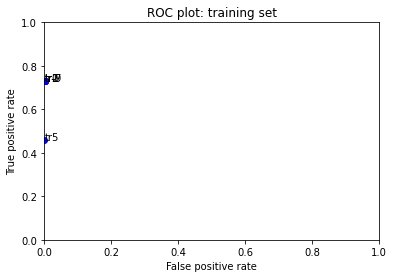

In [67]:
fits = [rdg_performance_train, rdg_performance_train_1, rdg_performance_train_2, rdg_performance_train_5, rdg_performance_train_7, rdg_performance_train_9]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, ])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [ ]:
ols_predictions = ols.predict(X_train)

In [ ]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# true positives

print("Examples of true positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [100]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)
print("False Positive Rate:")
print(ols_performance_test.performance_measures['FP'] / ols_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_test.performance_measures['TP'] / ols_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 1560, 'TN': 15224, 'FP': 13417, 'FN': 1714, 'Accuracy': 0.5258969136769545, 'Precision': 0.10415971155772184, 'Recall': 0.47648136835675015, 'desc': 'ols_test'}
False Positive Rate:
0.4684543137460284
True Positive Rate:
0.47648136835675015


### MODEL: SVM, linear

In [101]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)
print("False Positive Rate:")
print(svm_performance_test.performance_measures['FP'] / svm_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_test.performance_measures['TP'] / svm_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2291, 'TN': 27739, 'FP': 902, 'FN': 983, 'Accuracy': 0.9409368635437881, 'Precision': 0.7175070466645788, 'Recall': 0.6997556505803298, 'desc': 'svm_test'}
False Positive Rate:
0.0314933137809434
True Positive Rate:
0.6997556505803298


### MODEL: logistic regression

In [102]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test.performance_measures['FP'] / lgs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test.performance_measures['TP'] / lgs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2256, 'TN': 27776, 'FP': 865, 'FN': 1018, 'Accuracy': 0.9409995300015667, 'Precision': 0.7228452419096444, 'Recall': 0.6890653634697618, 'desc': 'lgs_test'}
False Positive Rate:
0.030201459446248385
True Positive Rate:
0.6890653634697618


### MODEL: Naive Bayes

In [103]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)
print("False Positive Rate:")
print(nbs_performance_test.performance_measures['FP'] / nbs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_test.performance_measures['TP'] / nbs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2509, 'TN': 26115, 'FP': 2526, 'FN': 765, 'Accuracy': 0.8968823437255209, 'Precision': 0.49831181727904666, 'Recall': 0.7663408674404398, 'desc': 'nbs_test'}
False Positive Rate:
0.08819524457944904
True Positive Rate:
0.7663408674404398


### MODEL: Perceptron

In [104]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)
print("False Positive Rate:")
print(prc_performance_test.performance_measures['FP'] / prc_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_test.performance_measures['TP'] / prc_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2270, 'TN': 27673, 'FP': 968, 'FN': 1004, 'Accuracy': 0.9382108726304246, 'Precision': 0.7010500308832612, 'Recall': 0.693341478313989, 'desc': 'prc_test'}
False Positive Rate:
0.03379770259418317
True Positive Rate:
0.693341478313989


### MODEL: Ridge Regression Classifier

In [74]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'test_0')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1715, 'TN': 28363, 'FP': 278, 'FN': 1559, 'Accuracy': 0.9424408585304715, 'Precision': 0.8605117912694431, 'Recall': 0.5238240684178375, 'desc': 'test_0'}


In [75]:
rdg_performance_test1 = BinaryClassificationPerformance(rdg1.predict(X_test), y_test, 'test_1')
rdg_performance_test1.compute_measures()
print(rdg_performance_test1.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1715, 'TN': 28364, 'FP': 277, 'FN': 1559, 'Accuracy': 0.9424721917593608, 'Precision': 0.8609437751004017, 'Recall': 0.5238240684178375, 'desc': 'test_1'}


In [76]:
rdg_performance_test2 = BinaryClassificationPerformance(rdg2.predict(X_test), y_test, 'test_2')
rdg_performance_test2.compute_measures()
print(rdg_performance_test2.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1715, 'TN': 28364, 'FP': 277, 'FN': 1559, 'Accuracy': 0.9424721917593608, 'Precision': 0.8609437751004017, 'Recall': 0.5238240684178375, 'desc': 'test_2'}


In [77]:
rdg_performance_test5 = BinaryClassificationPerformance(rdg5.predict(X_test), y_test, 'test_5')
rdg_performance_test5.compute_measures()
print(rdg_performance_test5.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1129, 'TN': 28609, 'FP': 32, 'FN': 2145, 'Accuracy': 0.931787560708131, 'Precision': 0.9724375538329026, 'Recall': 0.34483811850946855, 'desc': 'test_5'}


In [78]:
rdg_performance_test7 = BinaryClassificationPerformance(rdg7.predict(X_test), y_test, 'test_7')
rdg_performance_test7.compute_measures()
print(rdg_performance_test7.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1715, 'TN': 28363, 'FP': 278, 'FN': 1559, 'Accuracy': 0.9424408585304715, 'Precision': 0.8605117912694431, 'Recall': 0.5238240684178375, 'desc': 'test_7'}


In [79]:
rdg_performance_test9 = BinaryClassificationPerformance(rdg9.predict(X_test), y_test, 'test_9')
rdg_performance_test9.compute_measures()
print(rdg_performance_test9.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1715, 'TN': 28363, 'FP': 278, 'FN': 1559, 'Accuracy': 0.9424408585304715, 'Precision': 0.8605117912694431, 'Recall': 0.5238240684178375, 'desc': 'test_9'}


### MODEL: Random Forest Classifier

In [ ]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

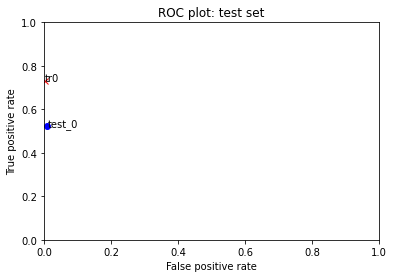

In [82]:
fits = [rdg_performance_test, rdg_performance_test1, rdg_performance_test2, rdg_performance_test5, rdg_performance_test7, rdg_performance_test9]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
fits = [rdg_performance_train, rdg_performance_train_1, rdg_performance_train_2, rdg_performance_train_5, rdg_performance_train_7, rdg_performance_train_9]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'rx')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)    

plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

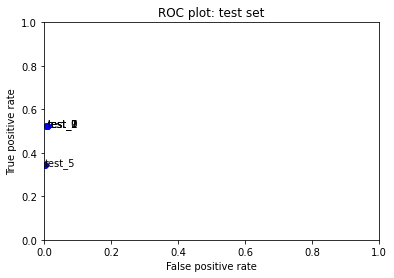

In [80]:
fits = [rdg_performance_test, rdg_performance_test1, rdg_performance_test2, rdg_performance_test5, rdg_performance_test7, rdg_performance_test9]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [ ]:
# # read in test data for submission
# # CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
# raw_data, X_test_submission = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_test.csv', my_random_seed=74, test=True)
# print("Number of rows in the submission test set (should be 153,164): ")

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# # store the id from the raw data
# my_submission = pd.DataFrame(raw_data["id"])
# # concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
# # look at the proportion of positive predictions
# print(my_submission['prediction'].mean())

In [ ]:
# raw_data.head()

In [ ]:
# my_submission.head()

In [ ]:
# my_submission.shape

In [ ]:
# # export submission file as pdf
# # CHANGE FILE PATH: 
# my_submission.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation